# Testing angles and branches

Following https://doi.org/10.1021/acs.jctc.7b00173 , compute the angle distributions.

First, consider propane and 2-methylpropane. Then consider a very flexible molecule as follows:

      1
      |
      0
     /  \
    2    3

Where the equilibrium angles are all 60 degrees but the harmonic angle potential is not strong. The bonds are rigid with a length of 2 and the diameters of the beads are 1.

In [1]:
import sys
import subprocess
import argparse
import random
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyfeasst import physical_constants

params = {
    "cubic_side_length": 90,
    "temperature_K": 300,
    "trials_per": 1e5,
    "production": 1e5,
    "k": 1,
    'angle_bin_width': 0.01,
    'angle_bin_center': 100/180*np.pi,
    'molecule': 'propane',
    #'molecule': '2-methylpropane',
    #'molecule': 'floppy_branch',
}

def update_params(params):
    params['seed'] = random.randrange(int(1e9))
    params['beta'] = 1./(params['temperature_K']*physical_constants.MolarGasConstant().value()/1e3) # mol/kJ
    if params['molecule'] == 'propane':
        params['system'] = """Configuration cubic_side_length 30 add_particles_of_type0 1 particle_type0 /feasst/particle/propane.fstprt
Potential Model LennardJones"""
        params['grow'] = 'particle_type 0 angle true mobile_site 2 anchor_site 1 anchor_site2 0'
    else:
        params['grow'] = 'particle_type 0 branch true mobile_site 2 mobile_site2 3 anchor_site 0 anchor_site2 1'
    if params['molecule'] == '2-methylpropane':
        params['system'] = """Configuration cubic_side_length 30 add_particles_of_type0 1 particle_type0 /feasst/particle/2-methylpropane.fstprt
Potential Model LennardJones"""
    elif params['molecule'] == 'floppy_branch':
        params['system'] = """Configuration cubic_side_length 30 add_particles_of_type0 1 particle_type0 {prefix}.fstprt
Potential Model HardSphere
Potential Model HardSphere VisitModel VisitModelIntraMap exclude_bonds true""".format(**params)
        with open(params['prefix']+'.fstprt', 'w') as file1:
            file1.write("""
4 sites
3 bonds
3 angles

1 site types
1 bond types
1 angle types

Site Properties

0 epsilon 1 sigma 1 cutoff 1

Sites

0 0 0 0 0
1 0 1 0 0
2 0 0 1 0
3 0 0 0 1

Bonds

0 0 0 1
0 0 0 2
0 0 0 3

Bond Properties

0 RigidBond length 1 delta 0.0001

Angles

0 0 1 0 2
0 0 1 0 3
0 0 2 0 3

Angle Properties

0 AngleHarmonic equilibrium_degrees 60 k_energy_per_radian_sq {k}
""".format(**params))
    else:
        if params['molecule'] != 'propane':
            assert False, 'unrecognized molecule'
        
def run_sim(params):
    update_params(params)
    with open(params['prefix']+'_grow.txt', 'w') as file1:
        file1.write("""TrialGrowFile\n\n{grow}""".format(**params))

    # write fst script to run a single simulation
    with open('script.txt', "w") as myfile: myfile.write("""
MonteCarlo
RandomMT19937 seed {seed}
{system}
ThermoParams beta {beta} chemical_potential 1
Metropolis
TrialGrowFile grow_file {prefix}_grow.txt
Movie trials_per_write {trials_per} output_file {prefix}.xyz
Log trials_per_write {trials_per} output_file {prefix}.txt include_bonds true
Energy trials_per_write {trials_per} output_file {prefix}_en.txt
AnalyzeBonds trials_per_write {trials_per} output_file {prefix}_bonds.txt angle_bin_width {angle_bin_width} angle_bin_center {angle_bin_center}
CheckEnergy trials_per_update {trials_per} tolerance 1e-8
Run num_trials {production}
""".format(**params))

    import subprocess
    syscode = subprocess.call("../../../build/bin/fst < script.txt > script.log", shell=True, executable='/bin/bash')
    with open('script.log', 'r') as file: print(file.read(), '\n', 'exit:', syscode)

In [2]:
params['prefix'] = params['molecule'] = 'propane'
params['production'] = params['trials_per'] = 1e7
run_sim(params)

# FEASST version: v0.24.5-3-g7548e16503-hwh/srswmonoclinic4
MonteCarlo
RandomMT19937 seed 331771759  
# initializing random number generator with seed: 331771759
Configuration add_particles_of_type0 1 cubic_side_length 30 particle_type0 /home/hwh/feasst/particle/propane.fstprt  
Potential Model LennardJones  
ThermoParams beta 0.4009078501424201 chemical_potential 1  
Metropolis  
TrialGrowFile grow_file propane_grow.txt  
Movie output_file propane.xyz trials_per_write 10000000.0  
Log include_bonds true output_file propane.txt trials_per_write 10000000.0  
Energy output_file propane_en.txt trials_per_write 10000000.0  
AnalyzeBonds angle_bin_center 1.7453292519943295 angle_bin_width 0.01 output_file propane_bonds.txt trials_per_write 10000000.0  
CheckEnergy tolerance 1e-8 trials_per_update 10000000.0  
Run num_trials 10000000.0  
 
 exit: 0


test (__main__.TestPropaneAngle) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


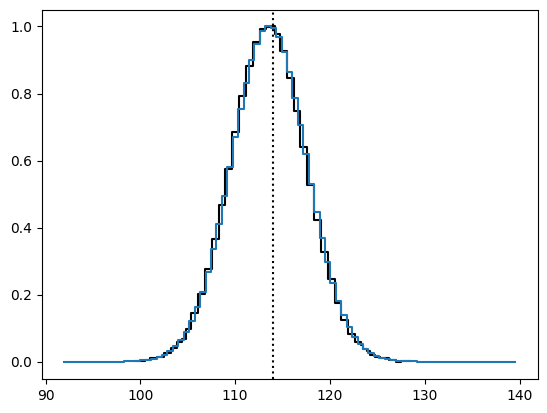

In [3]:
class TestPropaneAngle(unittest.TestCase):
    def test(self):
        chen = pd.read_csv('../test/data/propane_bonds.txt', comment='#', header=None)
        df = pd.read_csv('propane_bonds.txt', skiprows=10, header=None)
        for d in [df, chen]:
            d[1] /= d[1].max()
        self.assertAlmostEqual(chen[1].mean(), df[1].mean(), delta=0.2)
        self.assertAlmostEqual(chen[1].std(), df[1].std(), delta=0.1)
        plt.step(chen[0], chen[1], color='black')
        plt.step(df[0]/np.pi*180, df[1])
        plt.axvline(114, color='black', linestyle='dotted')
        
unittest.main(argv=[''], verbosity=2, exit=False)

In [4]:
params['prefix'] = params['molecule'] = '2-methylpropane'
params['production'] = params['trials_per'] = 1e5
run_sim(params)

# FEASST version: v0.24.5-3-g7548e16503-hwh/srswmonoclinic4
MonteCarlo
RandomMT19937 seed 451425423  
# initializing random number generator with seed: 451425423
Configuration add_particles_of_type0 1 cubic_side_length 30 particle_type0 /home/hwh/feasst/particle/2-methylpropane.fstprt  
Potential Model LennardJones  
ThermoParams beta 0.4009078501424201 chemical_potential 1  
Metropolis  
TrialGrowFile grow_file 2-methylpropane_grow.txt  
Movie output_file 2-methylpropane.xyz trials_per_write 100000.0  
Log include_bonds true output_file 2-methylpropane.txt trials_per_write 100000.0  
Energy output_file 2-methylpropane_en.txt trials_per_write 100000.0  
AnalyzeBonds angle_bin_center 1.7453292519943295 angle_bin_width 0.01 output_file 2-methylpropane_bonds.txt trials_per_write 100000.0  
CheckEnergy tolerance 1e-8 trials_per_update 100000.0  
Run num_trials 100000.0  
 
 exit: 0


test (__main__.Test2MethylpropaneAngle) ... ok
test (__main__.TestPropaneAngle) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.012s

OK


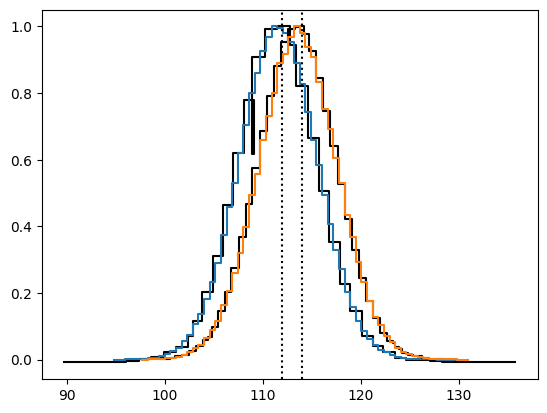

In [5]:
class Test2MethylpropaneAngle(unittest.TestCase):
    def test(self):
        chen = pd.read_csv('../test/data/2-methylpropane_bonds.txt', comment='#', header=None)
        df = pd.read_csv('2-methylpropane_bonds.txt', skiprows=10, header=None)
        for d in [df, chen]:
            d[1] /= d[1].max()
        self.assertAlmostEqual(chen[1].mean(), df[1].mean(), delta=0.4)
        self.assertAlmostEqual(chen[1].std(), df[1].std(), delta=0.2)
        plt.step(chen[0], chen[1], color='black')
        plt.step(df[0]/np.pi*180, df[1])
        plt.axvline(112, color='black', linestyle='dotted')
        
unittest.main(argv=[''], verbosity=2, exit=False)

In [2]:
# run simulations
ks = [1]
for k in ks:
    params['k'] = k
    params['prefix'] = "branchk" + str(params['k'])
    params['molecule'] = 'floppy_branch'
    params['production'] = params['trials_per'] = 1e7
    run_sim(params)

# FEASST version: v0.24.5-3-g7548e16503-hwh/srswmonoclinic4
MonteCarlo
RandomMT19937 seed 913109576  
# initializing random number generator with seed: 913109576
Configuration add_particles_of_type0 1 cubic_side_length 30 particle_type0 branchk1.fstprt  
Potential Model HardSphere  
Potential Model HardSphere VisitModel VisitModelIntraMap exclude_bonds true  
ThermoParams beta 0.4009078501424201 chemical_potential 1  
Metropolis  
TrialGrowFile grow_file branchk1_grow.txt  
Movie output_file branchk1.xyz trials_per_write 10000000.0  
Log include_bonds true output_file branchk1.txt trials_per_write 10000000.0  
Energy output_file branchk1_en.txt trials_per_write 10000000.0  
AnalyzeBonds angle_bin_center 1.7453292519943295 angle_bin_width 0.01 output_file branchk1_bonds.txt trials_per_write 10000000.0  
CheckEnergy tolerance 1e-8 trials_per_update 10000000.0  
Run num_trials 10000000.0  
 
 exit: 0


test (__main__.TestFloppyBranch) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


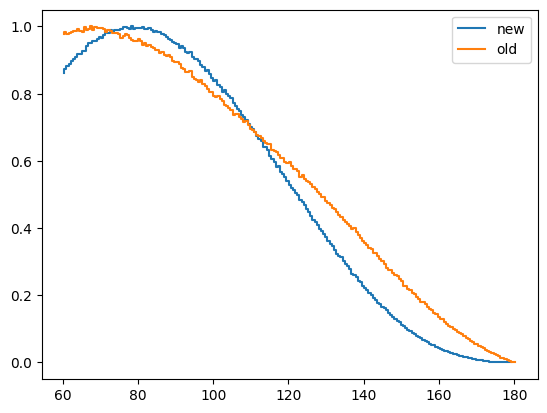

In [6]:
class TestFloppyBranch(unittest.TestCase):
    def test(self):
        for k in ks:
            params['k'] = k
            update_params(params)
            df = pd.read_csv("branchk"+str(k)+'_bonds.txt', skiprows=10, header=None)
            #print(df)
            #plt.axvline(60, color='black', linestyle='dotted')
            previous = pd.read_csv('../test/data/branchk'+str(k)+'_bonds.txt', skiprows=10, header=None)
            for d in [df, previous]:
                d[1] /= d[1].max()
            self.assertAlmostEqual(previous[1].mean(), df[1].mean(), delta=0.08)
            self.assertAlmostEqual(previous[1].std(), df[1].std(), delta=0.08)
            plt.step(df[0]/np.pi*180, df[1], label='new')#'k='+str(k))
            plt.step(previous[0]/np.pi*180, previous[1], label='old')#'k='+str(k))
            
        plt.legend()
        
unittest.main(argv=[''], verbosity=2, exit=False)

Did this tutorial work as expected? Did you find any inconsistencies or have any comments? Please [contact](../../../CONTACT.rst) us. Any feedback is appreciated!